# **EDA**
---
### **Imports & Setup**

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer

MODEL_NAME = "microsoft/deberta-v3-base"

train_path = "../data/processed/train.pkl"
val_path = "../data/processed/val.pkl"
test_path = "../data/processed/test.pkl"

### **Load Data**

In [4]:
train_df = pd.read_pickle(train_path)
val_df = pd.read_pickle(val_path)
test_df = pd.read_pickle(test_path)

all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"Total posts: {len(all_df)}")

Total posts: 14613


### **Calculate Token Len & Stats**

In [6]:
# --- Token Length Analysis ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

all_df['token_len'] = all_df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

# --- Stats ---
mean_len = all_df['token_len'].mean()
median_len = all_df['token_len'].median()
max_len = all_df['token_len'].max()
trunc_256 = (all_df['token_len'] > 256).mean() * 100
trunc_512 = (all_df['token_len'] > 512).mean() * 100

print("\n" + "=" * 40)
print(f"===== Token Length Statistics =====")
print(f"Mean Length:   {mean_len:.2f}")
print(f"Median Length: {median_len:.0f}")
print(f"Max Length:    {max_len}")
print("-" * 40)
print(f"===== Truncation Rate Analysis =====")
print(f"> 256 tokens:  {trunc_256:.2f}%  (Lost info if limit=256)")
print(f"> 512 tokens:  {trunc_512:.2f}%  (Lost info if limit=512)")
print("=" * 40)

/Users/sophia/venvs/nlp311/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



===== Token Length Statistics =====
Mean Length:   117.29
Median Length: 69
Max Length:    3275
----------------------------------------
===== Truncation Rate Analysis =====
> 256 tokens:  10.46%  (Lost info if limit=256)
> 512 tokens:  2.61%  (Lost info if limit=512)


### **Visualization**
#### 1. Token Length

/var/folders/rn/lvx6skrd52d2xfxt4jq5kbb80000gn/T/ipykernel_89720/3947585212.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label_name', y='token_len', data=all_df, order=order, ax=axes[1], palette="Set2", showfliers=False)


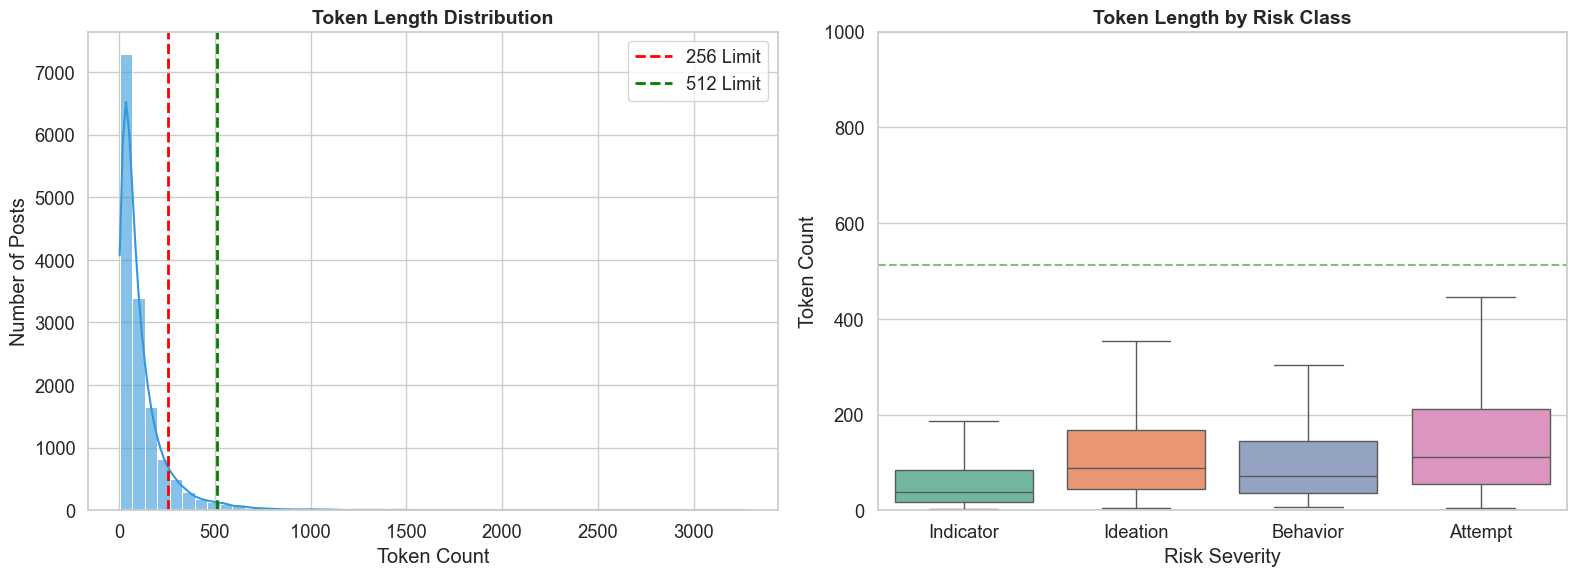

In [10]:
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# (A) Token Length Distribution
sns.histplot(all_df['token_len'], bins=50, kde=True, ax=axes[0], color='#3498db', alpha=0.6)
axes[0].axvline(256, color='red', linestyle='--', linewidth=2, label='256 Limit')
axes[0].axvline(512, color='green', linestyle='--', linewidth=2, label='512 Limit')
axes[0].set_title('Token Length Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Token Count')
axes[0].set_ylabel('Number of Posts')
axes[0].legend()

# (B) Length by Risk Class
# Mapping Label if not already done
label_map = {0: 'Indicator', 1: 'Ideation', 2: 'Behavior', 3: 'Attempt'}
if 'label_name' not in all_df.columns:
    all_df['label_name'] = all_df['label_ordinal'].map(label_map)
order = ['Indicator', 'Ideation', 'Behavior', 'Attempt']

sns.boxplot(x='label_name', y='token_len', data=all_df, order=order, ax=axes[1], palette="Set2", showfliers=False)
axes[1].axhline(512, color='green', linestyle='--', alpha=0.5, label='512 Limit')
axes[1].set_title('Token Length by Risk Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Risk Severity')
axes[1].set_ylabel('Token Count')
axes[1].set_ylim(0, 1000)

plt.tight_layout()
plt.show()

#### 2. Class Imbalance

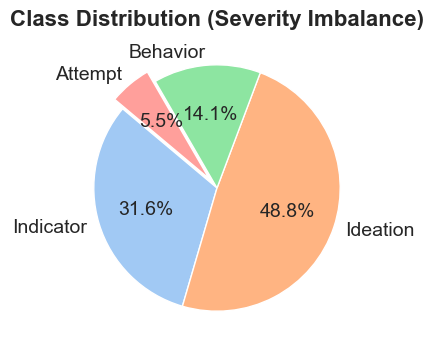

In [14]:
plt.figure(figsize=(4, 4))

class_counts = all_df['label_name'].value_counts()
counts = [class_counts.get(l, 0) for l in order]
colors = sns.color_palette('pastel')[0:4]
explode = [0, 0, 0, 0.1]

plt.pie(counts, labels=order, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, textprops={'fontsize': 14})
plt.title('Class Distribution (Severity Imbalance)', fontsize=16, fontweight='bold')
plt.show()

#### 3. Time Gap Analysis

/var/folders/rn/lvx6skrd52d2xfxt4jq5kbb80000gn/T/ipykernel_89720/878322512.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


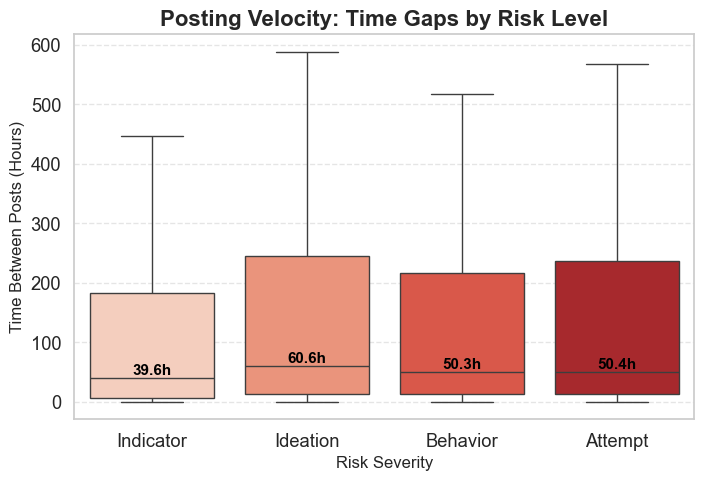

--- Median Time Gaps ---
label_name
Indicator    39.612083
Ideation     60.627083
Behavior     50.326111
Attempt      50.430833
Name: time_gap_hours, dtype: float64


In [16]:
# 1. Calculate Time Gaps
all_df = all_df.sort_values(by=['users', 'time'])
all_df['time_gap_hours'] = all_df.groupby('users')['time'].diff() / 3600

# 2. Filter for Visualization (Remove outliers > 95th percentile for clarity)
time_gap_df = all_df.dropna(subset=['time_gap_hours'])
upper_limit = time_gap_df['time_gap_hours'].quantile(0.95)
plot_df = time_gap_df[time_gap_df['time_gap_hours'] < upper_limit]

# 3. Plotting
plt.figure(figsize=(8, 5))
custom_palette = sns.color_palette("Reds", n_colors=4)

ax = sns.boxplot(
    x='label_name',
    y='time_gap_hours',
    data=plot_df,
    order=order,
    palette=custom_palette,
    showfliers=False
)

plt.title('Posting Velocity: Time Gaps by Risk Level', fontsize=16, fontweight='bold')
plt.ylabel('Time Between Posts (Hours)', fontsize=12)
plt.xlabel('Risk Severity', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add median text
medians = plot_df.groupby('label_name')['time_gap_hours'].median()
for i, label in enumerate(order):
    val = medians[label]
    ax.text(i, val + 5, f'{val:.1f}h', ha='center', fontsize=11, color='black', weight='bold')

plt.show()

print("--- Median Time Gaps ---")
print(medians.reindex(order))